<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression
The goal of a regression algorithm is to find out the relationship between two or more continuous variables. In this notebook we will try to compute the price of houses in Boston from a set of numerical features. The [Boston Housing](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) dataset is characterized by the small size of the dataset and by the different ranges of values of each feature. The dataset can be downloaded from Tensorflow. The features of the dataset are

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per 10000 dollars
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in $1000's

The target feauture is MEDV, the median value of owner-occupied homes

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

## Data normalization
It might be difficult for the model to deal with feautures with different ranges of values. A simple technique to avoid such problem is to standardize each feature by subtracting itm mean value and dividing by its standard deviation. We use only the training data to compute the normalization parameters.

In [4]:
mean = train_data.mean(axis=0) # compute the mean
train_data -= mean # subtract the mean
std = train_data.std(axis=0) # compute the standard deviation
train_data /= std # resize
test_data -= mean
test_data /= std

In [5]:
print('Minimum price: {0:.1f}$\nMaximum price: {1:.1f}$'.format(train_targets.min() * 1000, train_targets.max() * 1000))

Minimum price: 5000.0$
Maximum price: 50000.0$


## The regression model
We use only two fully connected layers with 64 units each and an output layer with one unit, without activation function, to build our regression model. Since the dataset is small keeping the model as small as possible will help to avoid the overfitting problem. We use the mean squared error ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error)) loss function, the [RMSprop optimizer](https://keras.io/api/optimizers/rmsprop/), and the mean absolute error ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)) as a metrics to estimate the performance of the model.

In [6]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-fold validation
Since the dataset is small, the performance might be different depending on what datapoints we use for validation. A better approach to train and validate a model with small datasets is to use k-fold validation. With this technique we split the dataset, after is has been shuffled, into k subsets, then we select the first subset for validation and the rest k-1 subsets are used for training. We train the model a certain number of epochs. Then we select the second subset and the previous one is put back into the k-1 subsets and then we train the model for the same number of epochs like before. We proceed till all the k subsets have been used.

In [7]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
all_scores

[1.9227489233016968,
 2.4594666957855225,
 2.3936655521392822,
 2.4030816555023193]

In [ ]:
print('Mean prediction error: {:.0f}$'.format(np.mean(all_scores) * 1000))

Mean prediction error: 2295$


We run the model for 500 epochs. We save the validation score for each epoch

In [9]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


We compute the average validation score per epoch over the four fold

In [10]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Then we plot the average validation score per epoch

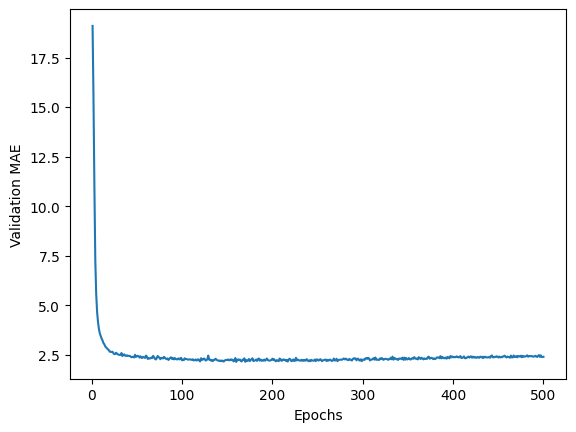

In [11]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

The validation score is much higher in the first 10 epochs than in the following ones, so we remove those 10 epochs. After the truncation we can see that the lowest validation error is achieved after 130 epoch, then the error start to increase again.

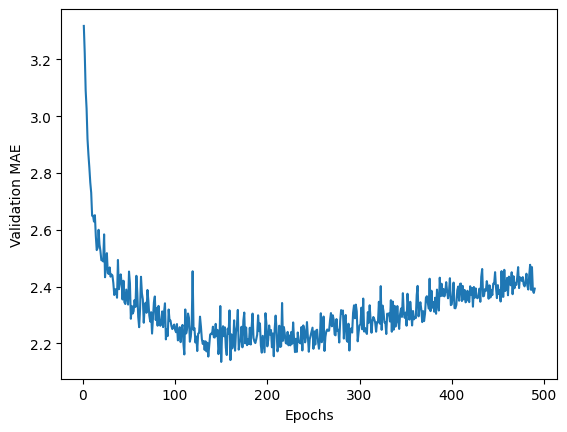

In [12]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

We create a new instance of the same model to be trained for 130 epochs

In [13]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 12.9300 - mae: 2.3148


In [14]:
print('Mean absolute error on the test set: {:.0f}$'.format(test_mae_score * 1000))

Mean absolute error on the test set: 2315$


We can use the model to make prediction, for example using the test data.

In [15]:
predictions = model.predict(test_data)

4/4 [==============================] - 0s 3ms/step


In [16]:
predictions[0] * 1000

array([7243.9106], dtype=float32)